# Forecasting
______________________________________________________

### Import Relevant Packages

In [5]:
# Package Importation
from __future__ import absolute_import, division, print_function, unicode_literals
import sys
from importlib import reload
import numpy as np
import requests
import pandas as pd
import bs4 as bs
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from datetime import date, timedelta
from os import listdir
from os import environ

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

import quandl

# GPU Utilization
from tensorflow.python.client import device_lib
environ["CUDA_VISIBLE_DEVICES"] = "-1" # Toggles GPU utilization
print("GPUs: ", device_lib.list_local_devices(), "\n")

'''
# Input functions from other notebook
import import_ipynb
from functions_1 import *
'''

# Import API keys
from API_keys import Quandl_api_key, AlphaVantage_api_key

# Check versions
print('python: {}'.format(sys.version))
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('pandas_datareader: {}'.format(pdr.__version__))
print('requests: {}'.format(requests.__version__))
print('bs4: {}'.format(bs.__version__))
#print('tensorflow: {}'.format(tf.version.VERSION))
#print('tensorflow: {}'.format(tf.__version__))

%matplotlib inline

# Quandl API Configuration
quandl.ApiConfig.api_key = Quandl_api_key

GPUs:  [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2037779567317422954
] 

python: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
pandas: 0.25.1
numpy: 1.16.5
pandas_datareader: 0.8.1
requests: 2.22.0
bs4: 4.8.0


### Include Files

In [11]:
from Forecasting_Exp_1_files.gen import network_construction
from Forecasting_Exp_1_files.gen import network_evaluation 
from Forecasting_Exp_1_files.gen import network_training
from Forecasting_Exp_1_files.gen import trading_evaluation 

from Forecasting_Exp_1_files.gen import collect_data

from Forecasting_Exp_1_files.gen import preprocessing
from Forecasting_Exp_1_files.gen import timeseries_preprocessing

def reload_gen():
    for entry in listdir('Forecasting_Exp_1_files/gen/'):
        if entry.endswith('.py'):
            reload(eval(entry.split('.')[0]))

In [12]:
# Date information
today = date.today()
year_ago = today - timedelta(days=365)
AAL_max = date(2005,9,27)
# Pull Stock Data
print("Pulling data from ", AAL_max, " to ", today)

data_dict = collect_data.update_data(start=AAL_max, end=today, overwrite_all = 1, ticker_subset = ['AAL'])


Pulling data from  2005-09-27  to  2020-01-01
Pulling Tickers from web
Pulling Yahoo price data from web
Pulling sentiment data from web


### Collect Individual DataFrames

In [13]:
AAL_df = data_dict["sp500_yahoo"].loc[data_dict["sp500_yahoo"]['Ticker'] == 'AAL']
AAL_df.reset_index(inplace=True, drop=True)

print('AAL_df columns: ')
print(AAL_df.columns)
print("")

sent_df = data_dict["sentiment"]
sent_df.reset_index(inplace=True, drop=True)

print('sent_df columns: ')
print(sent_df.columns)
print("")

AAL_df columns: 
Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close',
       'Ticker'],
      dtype='object')

sent_df columns: 
Index(['Date', 'Bullish', 'Neutral', 'Bearish', 'Total',
       'Bullish 8-Week Mov Avg', 'Bull-Bear Spread', 'Bullish Average',
       'Bullish Average + St. Dev', 'Bullish Average - St. Dev',
       'S&P 500 Weekly High', 'S&P 500 Weekly Low', 'S&P 500 Weekly Close'],
      dtype='object')



### Join DataFrames

In [14]:
master_df = timeseries_preprocessing.join_timeseries([AAL_df, sent_df], fill_nan_fwd = 1, snip_incomplete = 1)

master_df.to_excel(r'C:\Users\Mark\Documents\Trading_Notebooks\Forecasting_Exp_1_Data\temp\joined_df.xlsx')

### DataFrame Smoothing and Scaling

<Figure size 432x288 with 0 Axes>

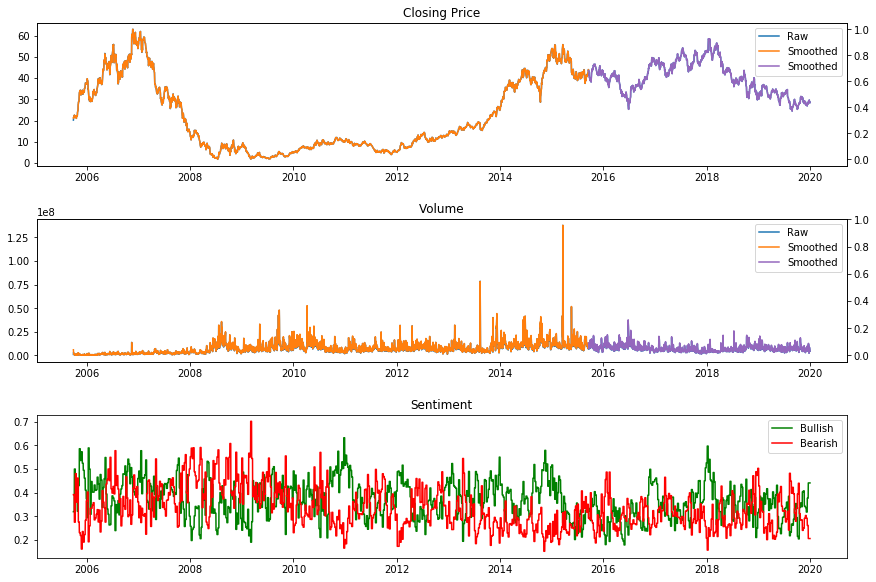

In [22]:
# Hyperparameter Definition

EMA = 0.0
gamma = 0.95
train_percent = 0.7
val_percent = 0.1

master_df_train, master_df_test = preprocessing.splitter(master_df, train_percent)

master_df_train_exclude = pd.DataFrame({'Date': master_df_train['Date'], 'Adj Close': master_df_train['Adj Close'], 
                                'Ticker': master_df_train['Ticker']})

master_df_train = master_df_train.drop(['Date', 'Adj Close', 'Ticker'], axis = 1)

master_df_test_exclude = pd.DataFrame({'Date': master_df_test['Date'], 'Adj Close': master_df_test['Adj Close'], 
                               'Ticker': master_df_test['Ticker']})

master_df_test = master_df_test.drop(['Date', 'Adj Close', 'Ticker'], axis = 1)

master_df_train_sm_sc, master_df_test_sm_sc = preprocessing.smoother_scaler(master_df_train, master_df_test, EMA, gamma)

for col in master_df_train_exclude.columns:
    master_df_train_sm_sc[col] = master_df_train_exclude[col].values
    
for col in master_df_test_exclude.columns:
    master_df_test_sm_sc[col] = master_df_test_exclude[col].values


plt.figure(1)
fig, axs = plt.subplots(3, 1, figsize=(12,8))

raw_close_line = axs[0].plot(master_df['Date'], master_df['Close'], label = "Raw", c = 'tab:blue')
axs01 = axs[0].twinx()  
sm_sc_train_close_line = axs01.plot(master_df_train_sm_sc['Date'], master_df_train_sm_sc['Close'], 
                                       label = "Smoothed", c = 'tab:orange')
sm_sc_test_close_line = axs01.plot(master_df_test_sm_sc['Date'], master_df_test_sm_sc['Close'], 
                                       label = "Smoothed", c = 'tab:purple')

raw_vol_line = axs[1].plot(master_df['Date'], master_df['Volume'], label = "Raw", c = 'tab:blue')
axs11 = axs[1].twinx()
sm_sc_train_vol_line = axs11.plot(master_df_train_sm_sc['Date'], master_df_train_sm_sc['Volume'], 
           label = "Smoothed", c = 'tab:orange')
sm_sc_test_vol_line = axs11.plot(master_df_test_sm_sc['Date'], master_df_test_sm_sc['Volume'], 
           label = "Smoothed", c = 'tab:purple')

raw_bull_line = axs[2].plot(master_df['Date'], master_df['Bullish'], 
            label = "Bullish", color='g')
raw_bear_line = axs[2].plot(master_df['Date'], master_df['Bearish'], 
            label = "Bearish", color='r')

axs[0].set_title("Closing Price")
axs[1].set_title("Volume")
axs[2].set_title("Sentiment")

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)

lns0 = raw_close_line + sm_sc_train_close_line + sm_sc_test_close_line
lns1 = raw_vol_line + sm_sc_train_vol_line + sm_sc_test_vol_line

labs0 = [l.get_label() for l in lns0]
axs[0].legend(lns0, labs0, loc=0)

labs1 = [l.get_label() for l in lns1]
axs[1].legend(lns1, labs1, loc=0)

axs[2].legend(['Bullish', 'Bearish'])

### Preparing to Run NN

In [23]:
'''
Hyperparameter Definition
'''

batch_size = 10 # Standard batch size
dropout = 0.1
epochs = 5
seq_length = 10
''''''

master_data_training = master_df_train_sm_sc.drop(['Date', 'Adj Close', 'Ticker'], axis = 1)
master_data_testing = master_df_test_sm_sc.drop(['Date', 'Adj Close', 'Ticker'], axis = 1)

X_train, y_train = timeseries_preprocessing.ltsm_sequence_generator(master_data_training, seq_length)



### Model Building

In [25]:
reload_gen()

model = network_construction.build_NN(X_train, batch_size, dropout)
model = network_construction.add_Optimizer(model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 20)            3040      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 20)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 20)            3280      
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 20)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 60)            19440     
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 60)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 600)              

### Model Training

Train on 2514 samples
Epoch 1/5
2514/2514 [==============================] - 8s 3ms/sample - loss: 0.0161
Epoch 2/5
2514/2514 [==============================] - 4s 2ms/sample - loss: 0.0024
Epoch 3/5
2514/2514 [==============================] - 4s 1ms/sample - loss: 0.0022
Epoch 4/5
2514/2514 [==============================] - 4s 1ms/sample - loss: 0.0019
Epoch 5/5
2514/2514 [==============================] - 4s 1ms/sample - loss: 0.0020


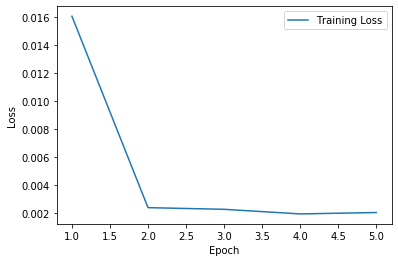

In [26]:
model, history = network_training.train_Model(model, X_train, y_train, epochs, batch_size)

# Get training and test loss histories
training_loss = history.history['loss']
#test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss)
#plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

### Save Model

In [27]:
save_dir = r'C:\Users\Mark\Documents\Trading_Documentation\Models_Saved'
model_name = r'\A00x'
save_path = save_dir + model_name

network_construction.save_model(model, save_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:\Users\Mark\Documents\Trading_Documentation\Models_Saved\A00x\assets


### Model Evaluation

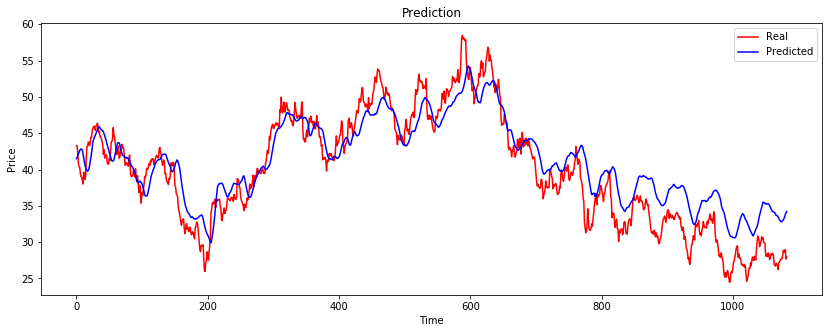

In [31]:
close_pred = network_evaluation.evaluate_performance(model, master_df_train, master_df_test, 
                                   master_data_training, master_data_testing, seq_length)

<IPython.core.display.Javascript object>


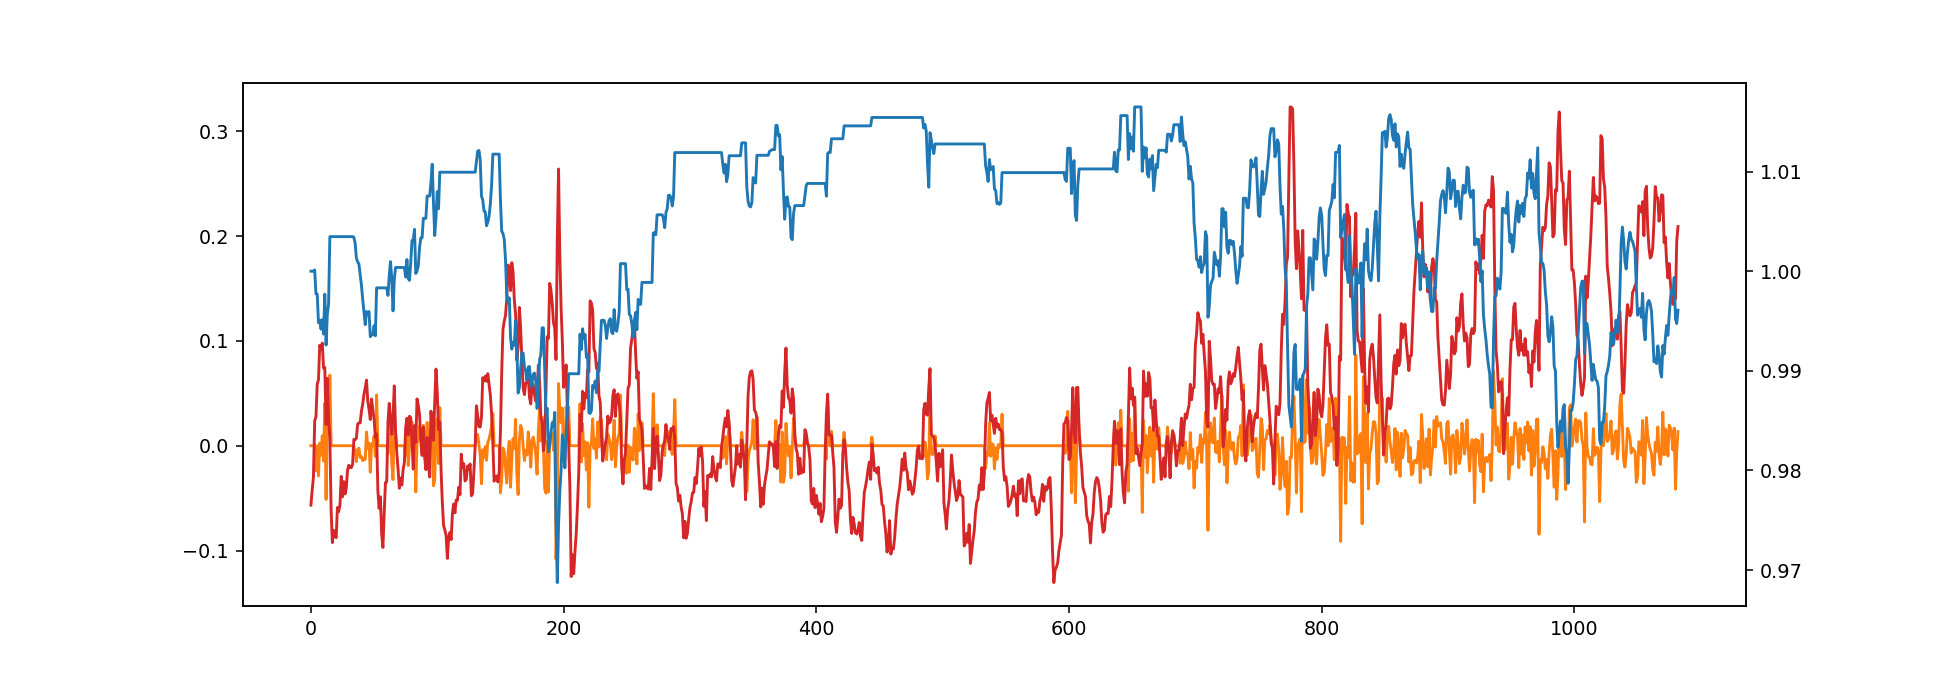

sum_percent_trading_error:  0.05705470010834932


In [34]:
%matplotlib nbagg

single_day_percentages, single_day_pred_changes, cumulative_percentages, sum_percent_trading_error = trading_evaluation.evaluate_model_AA001_day_ahead(
    close_pred, master_df_test['Close'].values, 
    master_df_train['Close'].values, 0.1)

print("sum_percent_trading_error: ", sum_percent_trading_error)

### Model and Hyperparameter Sweep 
***

_Data Preprocessing Parameters to Sweep:_
- Smoothing gamma

_Hyperparameters to Sweep:_ 
- seq_length 
- batch_size

_Model Architectural Parameters:_
- Number of LTSM layers
- Number of Dense layers
- Units of LTSM and Dense layers
- Ordering of LTSM and Dense layers
- Optimizer
- Loss function
- Activation function
- Dropout

_Information to Record:_
- Loss vs. Epoch
- evaluate_performance plot
- evaluate_model_AA001_day_ahead plot

In [35]:
reload_gen()

# Data Preprocessing Parameters to Sweep:
gamma_sweep_arr = np.logspace(np.log10(0.1), np.log10(1), num = 10, endpoint = True, base = 10.0)

# Hyperparameters to Sweep: 
batch_size_sweep_arr = np.array([1, 5, 10, 50])
seq_length_sweep_arr = np.array([5, 10, 50, 100, 150])

# Model Architectural Parameters:
dropout_sweep_arr = np.array([0.1, 0.2, 0.3]) # Later replace with for loop --> multiprocessing
activation_case_sweep_arr = np.array([0, 1, 2, 3]) # Later replace with for loop --> multiprocessing

fl_cases = [0, 1]
sl_cases = [0, 1]
tl_cases = [0, 1, 2]
layer_cases = np.array(np.meshgrid(fl_cases, sl_cases,tl_cases)).T.reshape(-1, 3)

flu_cases = [0, 1, 2, 3, 4]
slu_cases = [0, 1, 2, 3, 4]
tlu_cases = [0, 1, 2, 3, 4]
units_cases = np.array(np.meshgrid(flu_cases, slu_cases,tlu_cases)).T.reshape(-1, 3)


for layer_case in layer_cases:
    for units_case in units_cases:
        model = network_construction.model_mixer(X_train, 
                                         batch_size_sweep_arr[0], 
                                         dropout_sweep_arr[0], 
                                         activation_case_sweep_arr[0], 
                                         layer_case,
                                         units_case)

test4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 40)            9280      
_________________________________________________________________
dropout (Dropout)            (None, 10, 40)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 40)            12960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 40)            12960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 40)            0         
_________________________________________________________________
flatten (Flatten)            (None, 400)          

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 10, 60)            18720     
_________________________________________________________________
dropout_18 (Dropout)         (None, 10, 60)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 10, 60)            29040     
_________________________________________________________________
dropout_19 (Dropout)         (None, 10, 60)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 10, 40)            16160     
_________________________________________________________________
dropout_20 (Dropout)         (None, 10, 40)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 400)              

KeyboardInterrupt: 